In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import boxcox
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize_scalar
from scipy.optimize import brute
from scipy.optimize import fmin

In [2]:
boston_armed_robberies = pd.read_csv("monthly-boston-armed-robberies-j.csv")

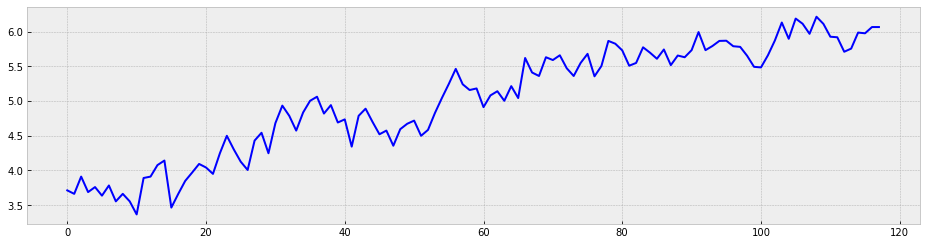

In [3]:
series = boxcox(boston_armed_robberies['Count'], 0)
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 4))
    plt.plot(series, color='blue')

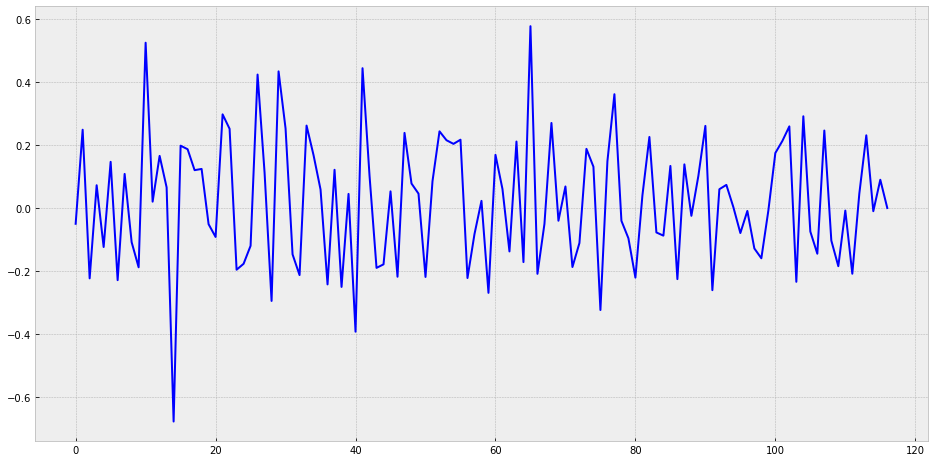

In [4]:
#стационарный ряд
series = np.diff(series, 1)   
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(series, color='blue')

In [5]:
# Скользящая средняя
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()


# Взвешенная скользящая средняя
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

# Экспоненцтальная скользящая средняя
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

# Двойная экспоненцтальная скользящая средняя
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

def plot_dema(series, alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [8]:
# Тройная экспоненцтальная скользящая средняя

def initial_trend(series, season_len):
    return sum([float(series[season_len] - series[0]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def plot_tema(alpha, beta, gamma, ser=boston_armed_robberies['Count'], ser_to_plot=boston_armed_robberies['Count'], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

Оценка качества на нестациоонарном ряде

In [9]:
train, val = boston_armed_robberies['Count'][:100], boston_armed_robberies['Count'][100:]
train_stat, val_stat = series[:100], series[100:]

In [10]:
def ma_cross_val(X, ser):
    n = int(X)
    #print((n))
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(ser):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = moving_average(train_split_ts, n)
        nan_count = len(result[result.isna()==True])
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions[nan_count+1:], test_split_ts[nan_count+1:])
        errors.append(error)

    return np.mean(np.array(errors))

In [11]:
def wma_cross_val(X, ser):
    f, s = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(ser):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = weighted_moving_average(train_split_ts, 2, [f, s])
        nan_count = len(result[result.isna()==True])
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions[nan_count:], test_split_ts[nan_count:])
        errors.append(error)
    
    return np.mean(np.array(errors))

In [12]:
def ema_cross_val(X, ser):
    alpha = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(ser):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = exponential_moving_average(train_split_ts, alpha)
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)

    return np.mean(np.array(errors))

In [13]:
def dema_cross_val(X, ser):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(ser):
        
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = double_ema(train_split_ts, alpha, beta)
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)

    return np.mean(np.array(errors))

In [14]:
def tema_cross_val(X, ser):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(ser):

        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [16]:
R2 = []

In [17]:
# качество на разных моделях скользящих средних на нестационаром и стационарном рядах: Скользящая средняя
ma_opt = brute(ma_cross_val, (slice(1,13,1),), args=(train,), full_output=True, finish=None)
ma_opt
print(ma_opt[0])

ma_train = moving_average(train, int(ma_opt[0]))
nan_count = len(ma_train[ma_train.isna()==True])
print(f'ma_train r2_score: {r2_score(train[nan_count:], ma_train[nan_count:]):,.3f}')

ma_stat_train = moving_average(train_stat, int(ma_opt[0]))
print(f'ma_stat_train r2_score: {r2_score(train_stat[nan_count:],ma_stat_train[nan_count:]):,.3f}')


ma_val = moving_average(val, int(ma_opt[0]))
nan_count = len(ma_val[ma_val.isna()==True])
print(f'ma_val r2_score: {r2_score(val[nan_count:], ma_val[nan_count:]):,.3f}')

ma_stat = moving_average(val_stat, int(ma_opt[0]))
print(f'ma_stat_val r2_score: {r2_score(val_stat[nan_count:], ma_stat[nan_count:]):,.3f}')

R2.append((r2_score(train[nan_count:], ma_train[nan_count:]),
          r2_score(train_stat[nan_count:],ma_stat_train[nan_count:]),
          r2_score(val[nan_count:], ma_val[nan_count:]),
          r2_score(val_stat[nan_count:], ma_stat[nan_count:])))

1.0
ma_train r2_score: 1.000
ma_stat_train r2_score: 1.000
ma_val r2_score: 1.000
ma_stat_val r2_score: 1.000


In [18]:
#качество на разных моделях скользящих средних на нестационаром и стационарном рядах: Взвешенная скользящая средняя
wma_opt = brute(wma_cross_val, (slice(1,20,1), slice(1,20,1)), args=(train,), full_output=True, finish=None)
print(wma_opt[0])

wma_stat_opt = brute(wma_cross_val, (slice(1,20,1), slice(1,20,1)), args=(train_stat,), full_output=True, finish=None)
print(wma_stat_opt[0])


wma_train = weighted_moving_average(train, 2, [*wma_opt[0]])
nan_count = len(wma_train[wma_train.isna()==True])
print(f'wma_train r2_score: {r2_score(train[nan_count:], wma_train[nan_count:]):,.3f}')
wma_stat_train = weighted_moving_average(train_stat, 2, [*wma_opt[0]])
nan_count = len(wma_stat_train[wma_stat_train.isna()==True])
print(f'wma_stat_train r2_score: {r2_score(train_stat[nan_count:], wma_stat_train[nan_count:]):,.3f}')


wma_val = weighted_moving_average(val, 2, [*wma_opt[0]])
nan_count = len(wma_val[wma_val.isna()==True])
print(f'wma_val r2_score: {r2_score(val[nan_count:], wma_val[nan_count:]):,.3f}')
wma_stat = weighted_moving_average(val_stat, 2, [*wma_opt[0]])
print(f'wma_stat_val r2_score: {r2_score(val_stat[nan_count:], wma_stat[nan_count:]):,.3f}')

R2.append((r2_score(train[nan_count:], wma_train[nan_count:]),
          r2_score(train_stat[nan_count:],wma_stat_train[nan_count:]),
          r2_score(val[nan_count:], wma_val[nan_count:]),
          r2_score(val_stat[nan_count:], wma_stat[nan_count:])))

[ 1. 19.]
[ 1. 19.]
wma_train r2_score: 1.000
wma_stat_train r2_score: 0.994
wma_val r2_score: 0.997
wma_stat_val r2_score: 0.994


In [19]:
#качество на разных моделях скользящих средних на нестационаром и стационарном рядах: Экспоненциальная скользящая средняя
ema_opt = minimize(ema_cross_val, x0=[0], args=(train,), method="Nelder-Mead")
print(ema_opt.x)
ema_stat_opt = minimize(ema_cross_val, x0=[0], args=(train_stat,), method="Nelder-Mead")
print(ema_stat_opt.x)


ema_train = exponential_moving_average(train, *ema_opt.x)
print(f'ema_train r2_score: {r2_score(train, ema_train):,.3f}')
ema_stat_train = exponential_moving_average(train_stat, *ema_stat_opt.x)
print(f'ema_stat_train r2_score: {r2_score(train_stat, ema_stat_train):,.3f}')


ema_val = exponential_moving_average(val.reset_index(drop=True), *ema_opt.x)
print(f'ema_val r2_score: {r2_score(val, ema_val):,.3f}')
ema_stat_val = exponential_moving_average(val_stat, *ema_stat_opt.x)
print(f'ema_stat_val r2_score: {r2_score(val_stat, ema_stat_val):,.3f}')

R2.append((r2_score(train, ema_train),
          r2_score(train_stat,ema_stat_train),
          r2_score(val, ema_val),
          r2_score(val_stat, ema_stat_val)))

[1.0565]
[1.0565]
ema_train r2_score: 1.000
ema_stat_train r2_score: 0.992
ema_val r2_score: 0.997
ema_stat_val r2_score: 0.992


In [20]:
#качество на разных моделях скользящих средних на нестационаром и стационарном рядах: Двойная Экспоненциальная скользящая средняя
dema_opt = minimize(dema_cross_val, x0=[0, 0], args=(train,), method="Nelder-Mead")
print(dema_opt.x)

dema_stat_opt = minimize(dema_cross_val, x0=[0, 0], args=(train_stat,), method="Nelder-Mead")
print(dema_stat_opt.x)


dema_train = double_ema(train, *dema_opt.x)
print(f'dema_train r2_score: {r2_score(train, dema_train):,.3f}')
dema_stat_train = double_ema(train_stat, *dema_stat_opt.x)
print(f'dema_stat_train r2_score: {r2_score(train_stat, dema_stat_train):,.3f}')


dema_val = double_ema(val.to_list(), *dema_opt.x)
print(f'dema_val r2_score: {r2_score(val, dema_val):,.3f}')
dema_stat_val = double_ema(val_stat, *dema_stat_opt.x)
print(f'dema_stat_val r2_score: {r2_score(val_stat, dema_stat_val):,.3f}')

R2.append((r2_score(train, dema_train),
          r2_score(train_stat,dema_stat_train),
          r2_score(val, dema_val),
          r2_score(val_stat, dema_stat_val)))

[0.77316625 0.18359827]
[0.77316625 0.18359827]
dema_train r2_score: 0.994
dema_stat_train r2_score: 0.854
dema_val r2_score: 0.772
dema_stat_val r2_score: 0.933


In [21]:
#качество на разных моделях скользящих средних на нестационаром и стационарном рядах:Тройная Экспоненциальная скользящая средняя
tema_opt = minimize(tema_cross_val, x0=[0, 0, 0], args=(train,), method="Nelder-Mead")
print(tema_opt.x)
tema_stat_opt = minimize(tema_cross_val, x0=[0, 0, 0], args=(train_stat,), method="Nelder-Mead")
print(tema_stat_opt.x)


tema_train = triple_exponential_smoothing(train, 12, *tema_opt.x, n_preds=0)
print(f'tema_train r2_score: {r2_score(train, tema_train):,.3f}')
tema_stat_train = triple_exponential_smoothing(train_stat, 12, *tema_stat_opt.x, n_preds=0)
print(f'tema_stat_train r2_score: {r2_score(train_stat, tema_stat_train):,.3f}')



tema_val = triple_exponential_smoothing(val.to_list(), 12, *tema_opt.x, n_preds=0)
print(f'tema_val r2_score: {r2_score(val, tema_val):,.3f}')
tema_stat_val = triple_exponential_smoothing(val_stat, 12, *tema_stat_opt.x, n_preds=0)
print(f'tema_stat_val r2_score: {r2_score(val_stat, tema_stat_val):,.3f}')

R2.append((r2_score(train, tema_train),
          r2_score(train_stat,tema_stat_train),
          r2_score(val, tema_val),
          r2_score(val_stat, tema_stat_val)))

[ 0.01956701  0.39902773 -0.06486833]
[ 0.01956701  0.39902773 -0.06486833]
tema_train r2_score: 0.851
tema_stat_train r2_score: 0.200
tema_val r2_score: -1.238
tema_stat_val r2_score: 0.047


In [22]:
pd.DataFrame(list(zip(*R2)), index=['train', 'train_stat', 'val', 'val_stat'], 
             columns=['MA', 'WMA', 'EMA', 'DEMA', 'TEMA']).round(3)

,MA,WMA,EMA,DEMA,TEMA
train,1.0,1.000,1.000,0.994,0.851
train_stat,1.0,0.994,0.992,0.854,0.200
val,1.0,0.997,0.997,0.772,-1.238
val_stat,1.0,0.994,0.992,0.933,0.047


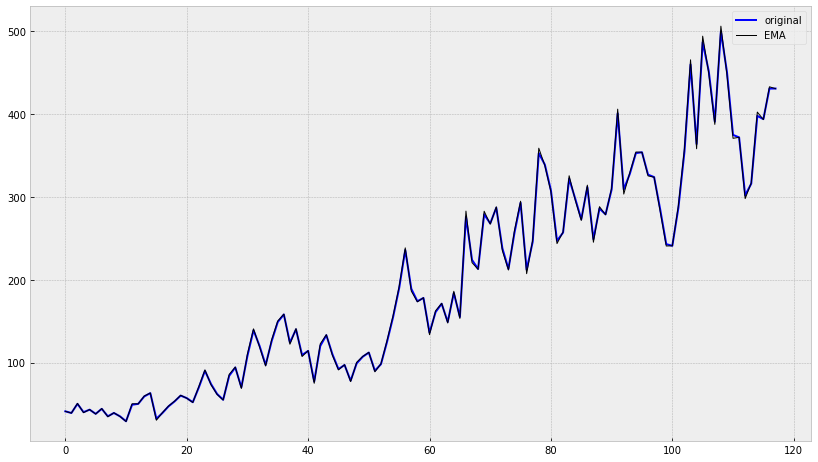

In [43]:
# Скользящие средние для нестационарного ряда EMA
ema = exponential_moving_average(boston_armed_robberies['Count'], ema_opt.x)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(boston_armed_robberies['Count'], color='blue',label='original')
    plt.plot(ema, color='black', linewidth='1', label='EMA')
    plt.legend()

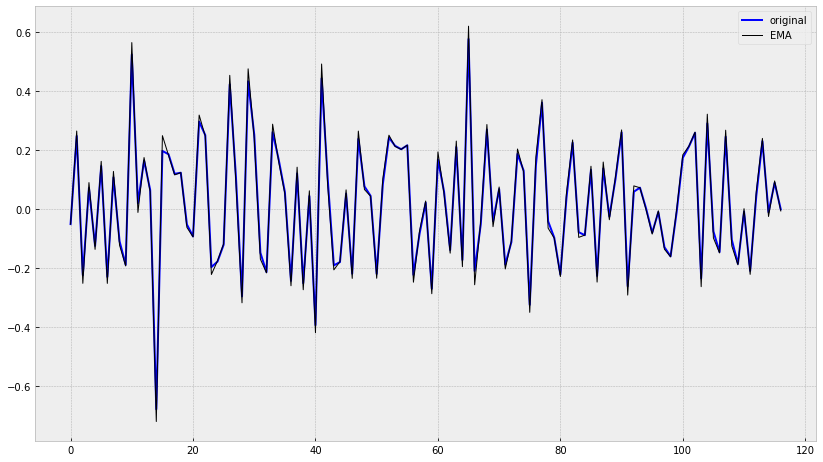

In [42]:
# Скользящие средние для стационарного ряда EMA
ema = exponential_moving_average(series, ema_stat_opt.x)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ema, color='black', linewidth='1', label='EMA')
    plt.legend()

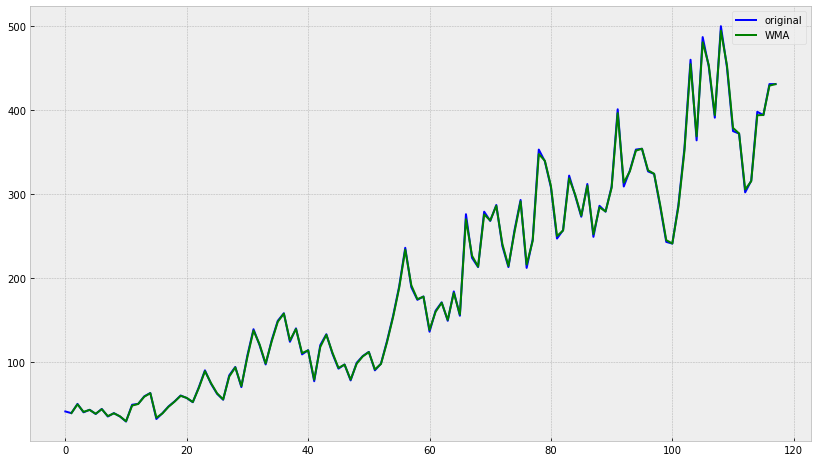

In [45]:
# Скользящие средние для нестационарного ряда WMA
wma = weighted_moving_average(boston_armed_robberies['Count'], 2, [*wma_opt[0]])
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(boston_armed_robberies['Count'], color='blue',label='original')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

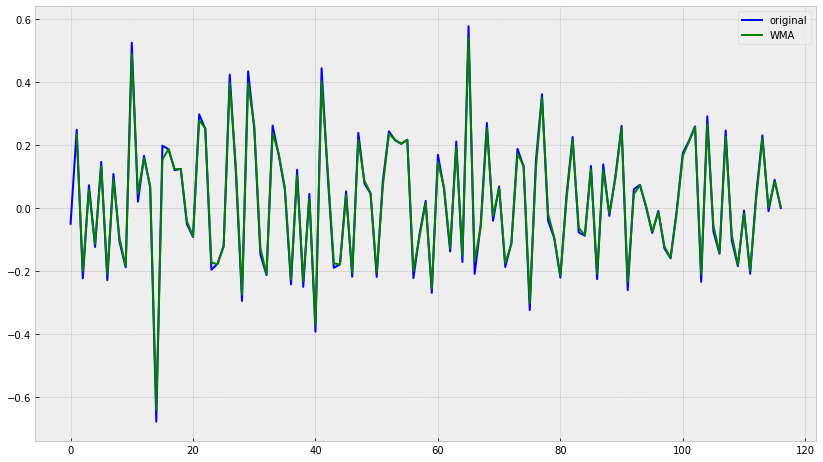

In [46]:
# Скользящие средние для стационарного ряда WMA
wma = weighted_moving_average(series, 2, [*wma_stat_opt[0]])
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

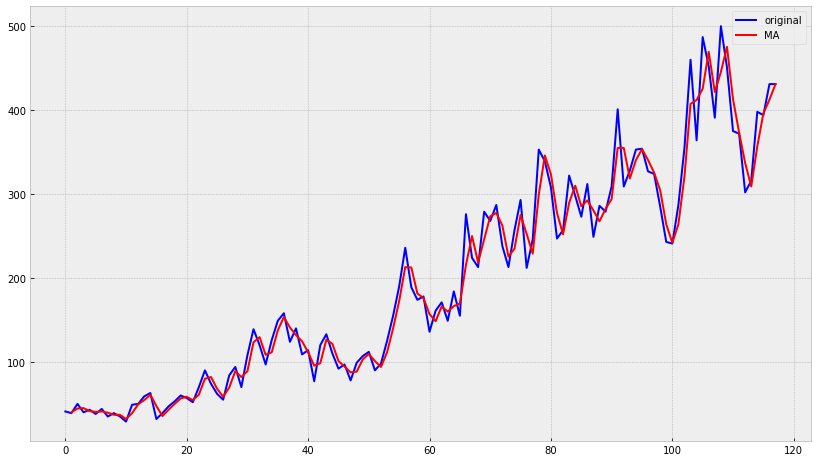

In [33]:
# Скользящие средние для нестационарного ряда MA
ma = moving_average(boston_armed_robberies['Count'], 2)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(boston_armed_robberies['Count'], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.legend()

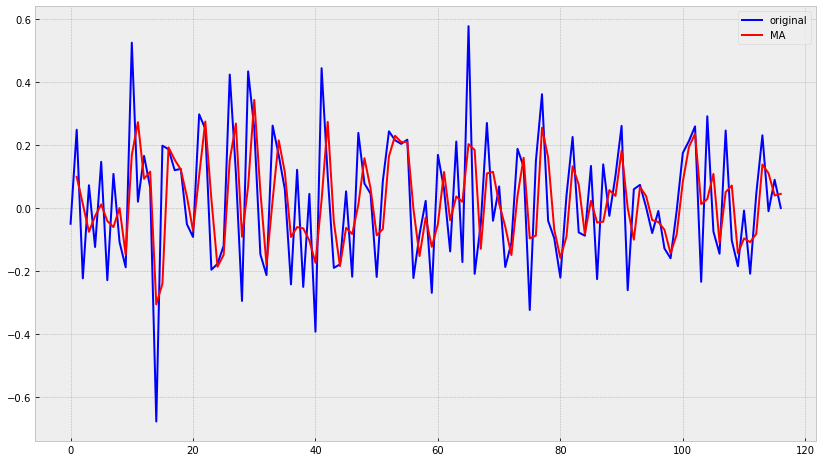

In [47]:
# Скользящие средние для стационарного ряда MA
ma = moving_average(series, 2)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.legend()

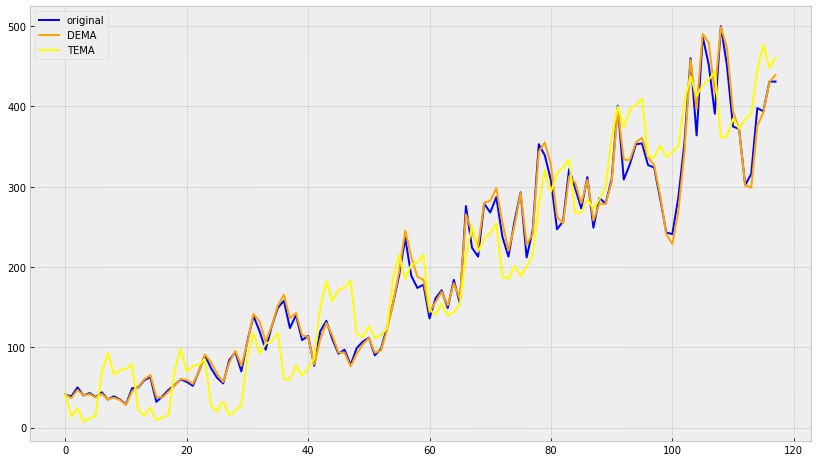

In [35]:
# Двойное экспоненциальное сглаживание DEMA и TEMA (нестационарн)
dema = double_ema(boston_armed_robberies['Count'], *dema_opt.x,)
tema = triple_exponential_smoothing(boston_armed_robberies['Count'], 12, *tema_opt.x, n_preds=0)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(boston_armed_robberies['Count'], color='blue',label='original')
    plt.plot(dema, color='orange', linewidth='2', label='DEMA')
    plt.plot(tema, color='yellow', linewidth='2', label='TEMA')
    plt.legend()

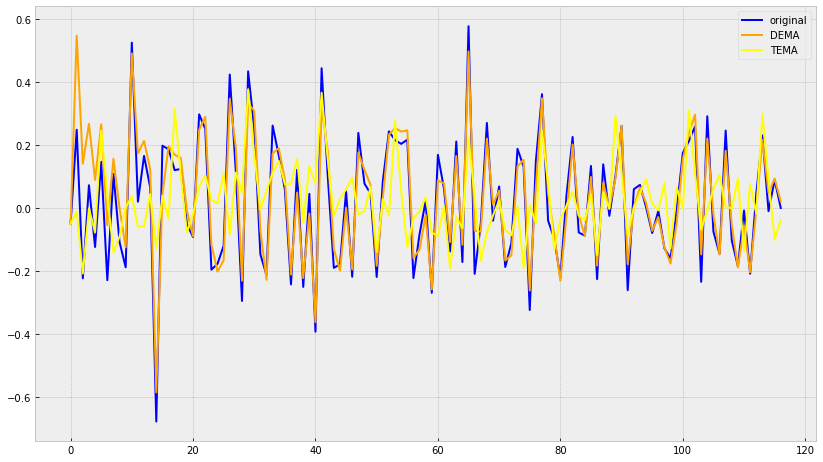

In [48]:
# Двойное экспоненциальное сглаживание DEMA и TEMA (стационарн)
dema = double_ema(series, *dema_stat_opt.x)
tema = triple_exponential_smoothing(series, 12, *tema_stat_opt.x, n_preds=0)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(dema, color='orange', linewidth='2', label='DEMA')
    plt.plot(tema, color='yellow', linewidth='2', label='TEMA')
    plt.legend()

# Все, кроме  TEMA, хорошо приближают. Лучше всего справляются EMA и WMA, качество ТЕМА низкое из-за остутствия сезонности